In [1]:
# https://www.kaggle.com/code/krishnaprasad96/siamese-network
# https://towardsdatascience.com/siamese-networks-line-by-line-explanation-for-beginners-55b8be1d2fc6
# https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee
# https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

# !pip install keras
# !pip install keras_utils
# !pip install plot_model
# !pip install hdbscan

import os, sys
import matplotlib.pyplot as plt, numpy as np
from PIL import Image
from matplotlib import markers
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
# sns.set_theme()
sns.reset_orig()

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda #, merge
from keras.layers import InputLayer, UpSampling2D, Concatenate, Reshape, Embedding, dot
from keras.models import Model, Sequential, load_model
from keras.regularizers import l2
from keras import backend as K
# from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from scipy import spatial
# from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

#from datetime import datetime

Mounted at /content/drive


In [ ]:
import random

base_dir = '/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/2024/Training/'
train_test_split = 0.7 # 70% para entrenamiento y 30% para validación
no_of_files_in_each_class = 100 # tomo una muestra de N imagenes por clase

#Read all the folders in the directory
folder_list = os.listdir(base_dir)
folder_list.sort()
print(len(folder_list), "clases para construir el modelo")

#Declare training array
cat_list = []
x = []
y = []
y_label = 0

for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name)) #una lista con los archivos de ese folder
    random.shuffle(files_list)  #randomizo
    temp=[] #va a hacer una lista de temp para cada folder
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x)) #en cada elemento del folder, agrega a temp
        # print(file_name)
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('L').resize((320,240))).reshape(320,240,1))
        # las imagenes de entrada se convierten a:
        #escala de grises .convert('L') # escalado .resize(width, height) la version original no lleva reshape
        y.append(y_label)
    y_label+=1 #contiene un numero que identifica a cada clase
    #cat_list.append(temp) # versión original de kaggle
    cat_list.append(np.asarray(temp)) #numeracion consecutiva

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape', x.shape, y.shape, cat_list.shape)

train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'clases para el entrenamiento, y', test_size, 'clases para validación')

train_files = train_size * no_of_files_in_each_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape de los datos de entrenamiento :',x_train.shape, 'y', y_train.shape, cat_train.shape)
print('X&Y shape de los datos de validación :' , x_val.shape, 'y', y_val.shape, cat_test.shape)
print("=============================================")

# for i in range(0,9):
#     plt.subplot(3, 3, i+1)
#     plt.axis('off')
#     plt.imshow(x_train[np.random.randint(0, x_train.shape[0]-1)], cmap='gray')
# plt.show()

def get_batch(batch_size):
    temp_x = x_train
    temp_cat_list = cat_train
    start=0
    end=train_size
    batch_x=[]

    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)

    # armamos un vector de batch_size de ceros y unos, mezclados.
    class_list = np.random.randint(start, end, batch_size)
    batch_x.append(np.zeros((batch_size, 320,240,1)))
    batch_x.append(np.zeros((batch_size, 320,240,1)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]
        # If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]
            batch_y[i] = 1 #agregado en esta nueva versión de Gonza/Gabo
        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            # print(temp_list)
            # print('1:',batch_x[0][i].shape)
            # print('2:',temp_x[np.random.choice(temp_list)].shape)
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]
            batch_y[i] = 0 #agregado en esta nueva versión de Gonza/Gabo
    return(batch_x, batch_y)

def nway_one_shot_val(model, n_way, n_val):
#    temp_x = x_val
#    temp_cat_list = cat_test
#    batch_x=[]
#    x_0_choice=[]
    n_correct = 0
    class_list = np.random.randint(train_size, len(folder_list), n_val)

    for i in class_list:
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 320, 240,1)))
        temp.append(np.zeros((n_way, 320, 240,1)))
        for k in range(0, n_way):
            temp[0][k] = x[j]
            if k==0:
                # print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                # print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        result = model.predict(temp, verbose=0)
        result = result.flatten().tolist()
        # print(result)
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "clasificadas correctamente de", n_val)
    # print(temp[0].shape)
    accuracy = (n_correct*100)/n_val
    return accuracy

def nway_one_shot_train(model, n_way, n_val):
#    temp_x = x_val
#    temp_cat_list = cat_test
#    batch_x=[]
#    x_0_choice=[]
    n_correct = 0
    class_list = np.random.randint(0, train_size, n_val)

    for i in class_list:
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 320, 240,1)))
        temp.append(np.zeros((n_way, 320, 240,1)))
        for k in range(0, n_way):
            temp[0][k] = x[j]
            if k==0:
                #print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                #print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:train_size].flatten()))]

        result = model.predict(temp, verbose=0)
        result = result.flatten().tolist()
        # print(result)
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "clasificadas correctamente de", n_val)
    # print(temp[0].shape)
    accuracy = (n_correct*100)/n_val
    return accuracy

# https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/
def contrastive_loss(y, preds, margin=2):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

batch_size = 64 # 128
batch_x, batch_y = get_batch(batch_size)
# batch_x is a list of 2 elements.
# Each element contains a number #batch_size sonograms
# batch_y is 0 is those elements are from the same class

#Building a sequential model
input_shape=(320, 240, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3,3), strides=2, activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init,
                        kernel_regularizer=l2(2e-4)), #(10, 10)
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    #keras.layers.Dropout(0.5),

    keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    #keras.layers.Dropout(0.5),

    keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2), #(1,2)
    #keras.layers.Dropout(0.5),

    keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),

    keras.layers.Dense(1024, activation='relu', kernel_initializer=W_init, bias_initializer=b_init,kernel_regularizer=l2(2e-4)),
    keras.layers.Dense(3, activation='linear', kernel_initializer=W_init, bias_initializer=b_init) # "sigmoid"
])

encoded_l = model(left_input)
encoded_r = model(right_input)

# Add a customized layer to compute the absolute difference between the encodings
# L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_layer = Lambda(lambda tensors:tensors[0] - tensors[1])

# subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
L1_distance = L1_layer([encoded_l, encoded_r])

vector_norm = keras.layers.dot([L1_distance, L1_distance], axes=1)
# final_layer = Lambda(lambda tensors:K.log(tensors))(vector_norm)

# Add a dense layer with a sigmoid unit to generate the similarity score
# prediction = Dense(1,activation='sigmoid', use_bias=False)(vector_norm)

siamese_net = Model([left_input, right_input], vector_norm)  # modelo completo
# distance_net = Model([left_input, right_input], vector_norm)
encoder = Model([left_input],encoded_l) #codificador para emplear la red

optimizer= tf.keras.optimizers.Adam(0.0001) #0.0006

# siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)
siamese_net.compile(loss=contrastive_loss, optimizer=optimizer)

# tf.keras.utils.plot_model(siamese_net, show_shapes=True, show_layer_names=True)
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
# model.summary()

epochs = 3501   # 2501
n_way = 70      # número de formas para cada paso de validación: 20 (35)
n_val = 90      # cantidad de DATOS para probar en la validación: 25 (35)
batch_size = 64 # 128
epoch_step = 250

loss_list=[]
accuracy_list_val=[]
accuracy_list_train=[]

for epoch in range(1,epochs):
    #batch_x, batch_y = get_batch(batch_size, call_type="train")
    batch_x, batch_y = get_batch(batch_size)
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append((epoch,loss))
    # print('Epoca:', epoch, ', Loss:',loss)
    if epoch%epoch_step == 0:
        accuracy_train = nway_one_shot_train(siamese_net, n_way, n_val)
        accuracy_list_train.append((epoch, accuracy_train))
        accuracy_val = nway_one_shot_val(siamese_net, n_way, n_val)
        accuracy_list_val.append((epoch, accuracy_val))
        print('Exactitud en el entrenamiento luego de', epoch, 'epocas:', accuracy_train)
        print('Exactitud en la validación luego de', epoch, 'epocas:', accuracy_val)
        print("=============================================")
        if(accuracy_val>95):
            print("Se obtuvo una exactitud superior al 95%")
            # break

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(*zip(*loss_list))
ax.set_ylabel('Loss')
ax2.plot(*zip(*accuracy_list_train), label='Train')
ax2.plot(*zip(*accuracy_list_val), label='Test')
ax2.legend()
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0,105)
plt.show()

siamese_net.save_weights('/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/2024/Modelos/Modelo_Tesis_70%_N90_D3_3x3 (35).h5')
# now = datetime.now()
# dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
# siamese_net.save_weights('/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/2024/Modelos/Modelo_'+ str(dt_string)+ '.h5')
# siamese_net.load_weights('/content/drive/MyDrive/Investigación_LSD/RedesSiamesas/2024/Modelos/Modelo5_3.h5')

In [ ]:
indices_totales = x_train.shape[0]
lista_coordenadas = []
lista_clases = []
for i in range(indices_totales):
    lista_coordenadas.append(encoder.predict([x_train[i].reshape(1,320,240,1)], verbose=0)[0])
    lista_clases.append(y_train[i])
lista_coordenadas = np.asarray(lista_coordenadas)

indices_totales_val = x_val.shape[0]
lista_coordenadas_val = []
lista_clases_val = []
for i in range(indices_totales_val):
    lista_coordenadas_val.append(encoder.predict([x_val[i].reshape(1,320,240,1)], verbose=0)[0])
    lista_clases_val.append(y_val[i])
lista_coordenadas_val = np.asarray(lista_coordenadas_val)

# print(lista_coordenadas)
# print(lista_coordenadas_val)

angulo_1 = 20
angulo_2 = 70

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(lista_coordenadas[:,0], lista_coordenadas[:,1], lista_coordenadas[:,2], c=lista_clases)
# ax.scatter(lista_coordenadas_val[:,0], lista_coordenadas_val[:,1], lista_coordenadas_val[:,2], c=lista_clases_val,marker="X")
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
plt.title('Clases de Entrenamiento')
ax.view_init(angulo_1, angulo_2)

x_limites = ax.get_xlim()
y_limites = ax.get_ylim()
z_limites = ax.get_zlim()

ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(lista_coordenadas_val[:,0], lista_coordenadas_val[:,1], lista_coordenadas_val[:,2], c=lista_clases_val)
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_zlabel('Dim 3')
ax1.set_xlim(x_limites)
ax1.set_ylim(y_limites)
ax1.set_zlim(z_limites)
plt.title('Clases de Validación')
ax1.view_init(angulo_1, angulo_2)
plt.tight_layout()
plt.show()

Varianza muestral por componente principal: [0.4606 0.3143 0.2251]
Componentes =  3 ; Varianza total explicada =  100.00 %

Varianza muestral por componente principal: [0.7916 0.1382 0.0702]
Componentes =  3 ; Varianza total explicada =  100.00 %


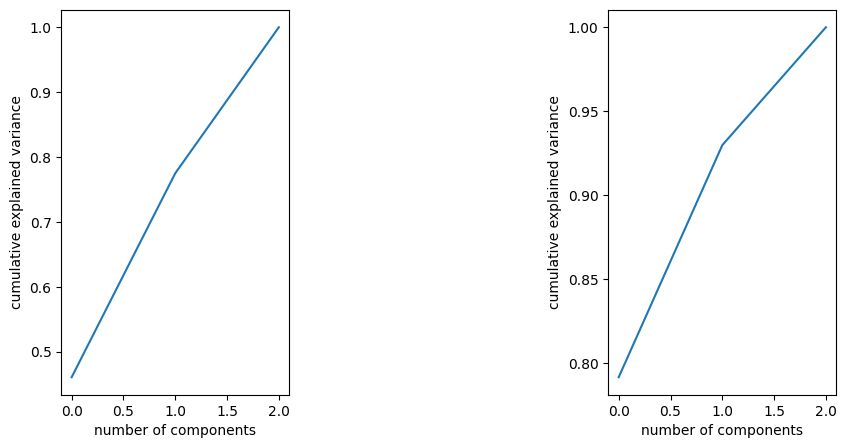

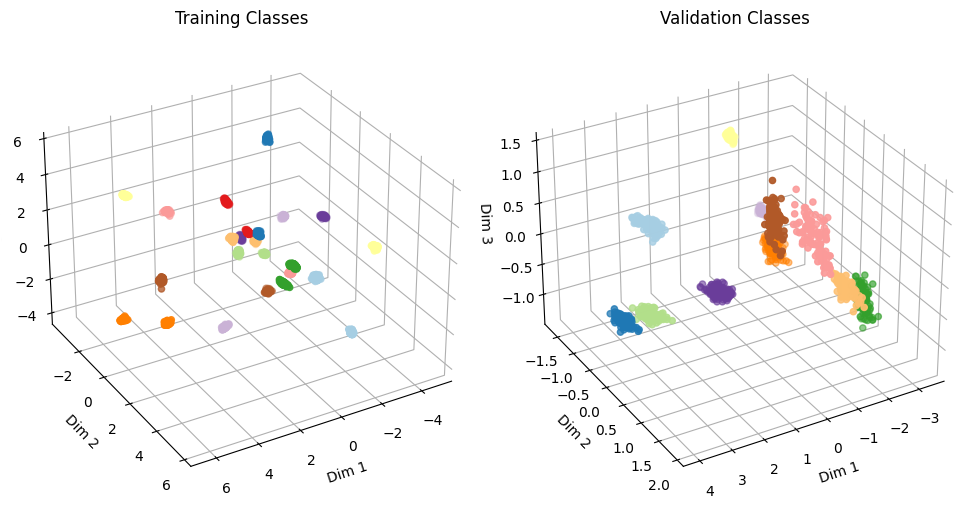

In [4]:
"""
np.set_printoptions(precision=4, suppress=True)

pca = PCA(3)
reduccion = pca.fit_transform(lista_coordenadas)
print("Varianza muestral por componente principal: {}".format(pca.explained_variance_ratio_))
print("Componentes = ", pca.n_components_ , "; Varianza total explicada = ",
      "%.2f" % round(pca.explained_variance_ratio_.sum()*100,5), '%')
# print(pca.components_)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(131)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance')

print()

pca2 = PCA(3)
reduccion2 = pca2.fit_transform(lista_coordenadas_val)
print('Varianza muestral por componente principal: {}'.format(pca2.explained_variance_ratio_))
print("Componentes = ", pca2.n_components_ , "; Varianza total explicada = ",
      "%.2f" % round(pca2.explained_variance_ratio_.sum()*100,5), '%')

ax1 = fig.add_subplot(133)
ax1.plot(np.cumsum(pca2.explained_variance_ratio_))
ax1.set_xlabel('number of components')
ax1.set_ylabel('cumulative explained variance')

plt.set_cmap('Paired')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(reduccion[:,0], reduccion[:,1], reduccion[:,2], c=lista_clases)
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
#ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
plt.title('Training Classes')
ax.view_init(30, 60)

ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(reduccion2[:,0], reduccion2[:,1], reduccion2[:,2], c=lista_clases_val)
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_zlabel('Dim 3')
plt.title('Validation Classes')
#ax1.grid(False)
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
ax1.xaxis.pane.set_edgecolor('w')
ax1.yaxis.pane.set_edgecolor('w')
ax1.zaxis.pane.set_edgecolor('w')
ax1.view_init(30, 60)
plt.tight_layout()
plt.show()
"""

Ver si hay algo útil:
https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/
